In [1]:
import warnings
warnings.filterwarnings(action='ignore')

# 3.1 MNIST

In [2]:
#MNIST 데이터셋 내려받는 코드
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

### 사이킷런에서 읽어 들인 데이터 셋 딕셔너리 구조
*  데이터셋을 설명하는 DESCR 키
*  샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data키
*  레이블 배열을 담은 target 키

In [3]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


### 데이터셋에서 이미지 확인하기

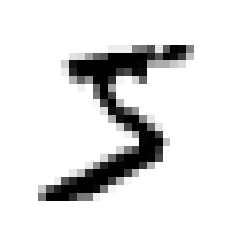

5
실제 레이블 :  None
<class 'str'>


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

print("실제 레이블 : ", print(y[0]))
print(type(y[0]))

In [5]:
#레이블 값 정수로 변환
y = y.astype(np.uint8)
print(type(y[0]))

<class 'numpy.uint8'>


### 훈련 / 테스트 데이터 Split
*  어떤 학습 알고리즘은 훈련 샘플의 순서에 민감해서 비슷한 샘플이 연이어 나타나면 성능 저하 발생
*  따라서 데이터셋을 섞어서 이러한 문제를 방지

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 3.2 이진 분류기 훈련

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [8]:
#사이컷런의 SGDClassifier를 사용한 확률적 경사 하강법 분류기(SGD)
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=22)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=22, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

[ True]


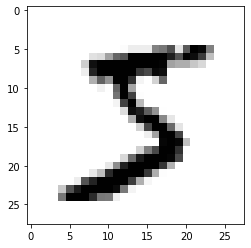

In [9]:
#sgd 모델을 사용한 숫자 5 이미지 감지
print(sgd_clf.predict([some_digit]))
plt.imshow(some_digit_image, cmap='binary')
plt.show()

#이 이미지를 5라고 예측

# 3.3 성능 측정

## 3.3.1 교차 검증을 사용한 정확도 측정

In [10]:
#StratifiedKFold : 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행
#매 반복마다 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=11)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred), end = ' ')

0.9679 0.964 0.9542 

In [11]:
#cross_val_score() : k-겹 교차 검증
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = "accuracy")

array([0.9679, 0.964 , 0.9542])

In [12]:
#모든 이미지를 5아님 클래스로 분류하는 더미 분류기
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

-이 결과는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여준다.
불균형한 데이터셋을 다룰 때 더욱 그렇다.

---

## 3.3.2 오차 행렬

In [13]:
#한번도 사용하지 않은 데이터 샘플 사용
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[54149,   430],
       [ 1848,  3573]], dtype=int64)

### 오차 행렬
*  오차 행렬의 행은 실제 클래스 / 열은 예측한 클래스를 나타낸다.
*  첫 번째 행 Negative Class (5아님) / 두번째 행 Postive Class(5 맞음)
*  True Negative : 54149 / 5 아님을 정확하게 분류
*  Fasle Postive : 430 / 5 라고 잘못 분류
*  False Negative : 1848 / 5 아님으로 잘못 분류
*  True Postive : 3573 / 정확히 5라고 분류

### 정밀도(Precision)
 *  양성 예측의 정확도 <br>
 *  정밀도 = TP / (TP + FP)

### 재현율(Recall, 민감도 Sensitivity)
 * 분류기가 정확하게 감지한 양성  샘플의 비율<br>
 * 재현율 = TP / (TP + FN)
 
### F점수 (F score)
* 두 분류기를 비교할 때 유용
* 정밀도와 재현율의 조화 평균
* F_score = 2 / ((1 / 정밀도) + (1 / 재현율))
          = 2 * 정밀도 * 재현율 / (정밀도 + 재현율)
          = TP / (TP + ((FN + FP) /2))

In [15]:
#정밀도
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
#정확도
print(recall_score(y_train_5, y_train_pred))

0.8925805645765675
0.659103486441616


In [16]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.758276740237691

## 3.3.4 정밀도 / 재현율 트레이드 오프
* 정밀도 ↑ -> 재현율 ↓ / 정밀도 ↓ -> 재현율 ↑
* 결정함수(Decision Function)을 사용하여 각 샘플의 점수를 계산
* 이 점수가 임계값보다 크면 샘플을 양성 클래스에, 그렇지 않으면 음성 클래스에 할당
* 임계값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인할 수 있다

In [17]:
#decision_function() : 각 샘플의 점수를 획득
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
#이 점수를 기반으로 원하는 임계값을 정해 예측을 만들 수 있다.
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[3875.06838355]
[ True]


In [18]:
#임계값 높여버리기
threshold = 8000
y_seom_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

### 적절한 임계값 정하기
1. cross_val_predict() 함수를 사용해 훈련 세트에 있는 모든 샘플의 점수 구하기
   (대신 예측 결과가 아닌 결정 점수를 반환)
2. precision_recall_curve() 함수를 사용해 가능한 모든 임계값에 대해 정밀도와 재현율 계산
3. matplotlib를 이용해 정밀도 / 재현율 그리기

In [19]:
# 1
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [20]:
#2
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

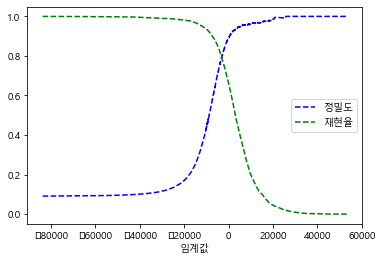

In [21]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
font_location = "c:/Windows/Fonts/malgun.ttf"
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)
%matplotlib inline


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
    plt.plot(thresholds, recalls[:-1], "g--", label="재현율")
    plt.xlabel("임계값")
    plt.legend()


plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [22]:
#정밀도 90%이상을 목표 ( 정밀도 90% / 재현율 63%로 타협)
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9001564129301356
0.636967349197565


## 3.3.5 ROC 곡선
### 수신기 조작 특성(Receiver Operating Characteristic)
* 거짓 양성 비율(False Postive Rate, FPR) : 양성으로 잘못 분류된 음성 샘플의 비율
* 진짜 음성 비율(True Postive Rate, TPR)
* ROC = FPR에 대한 TPR의 곡선
* 특이도(Specificity) : 진짜 음성 비율(True Negative Rate, TNR)
* 민감도(재현율) : 1 - 특이도(TNR)

In [23]:
#roc_curve()를 사용해 fpr, tpr 구하기
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

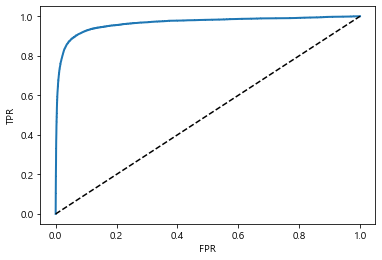

In [24]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    #대각점선
    plt.plot([0.,1], [0, 1], 'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
plot_roc_curve(fpr, tpr)
plt.show()

* 곡선 아래의 면적(Area Under the Curve, AUC)을 측정하여 분류기들을 비교

In [25]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.965116163330197

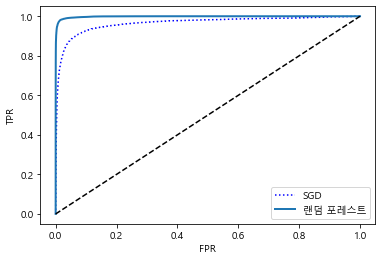

In [26]:
#RandomForestClassifier() : 랜덤분류기는 훈련 데이터의 클래스 비율을 따라 무작위로 예측
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc='best')
plt.show()

In [27]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# 3.4 다중 분류
* 이진 분류 : 두 개의 클래스를 구별 / 다중 분류기 : 둘 이상의 클래스를 구별

### 다중 클래스를 분류하는 기법
* OvR(One-versus-Rest) : 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택
* OvO(One-versus-One) : 각 숫자의 조합마다 이진 분류기를 훈련시키는 것
  (클래스가 N개라면 분류기는 N*(N -1)/2 개가 필요
* 일부 알고리즘은 훈련 세트의 크기에 민감해서 큰 훈련 세트에서 몇 개의 분류기를 훈련시키는 것보다 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빠르므로 OvO 선호
* 하지만 대부분 이진 분류 알고리즘에서는 OvR을 선호한다.

In [28]:
#Suppor Vector Mechine, SVC
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])
#내부에서는 사이킷런이 OvO전략을 사용해 10개의 이진 분류기를 훈련시키고,
#각각의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택

array([5], dtype=uint8)

In [29]:
#정말 그런지 확인
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores
#가장 높은 점수가 클래스 5에 해당

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [30]:
print(np.argmax(some_digit_scores))
print(svm_clf.classes_)
print(svm_clf.classes_[5])

5
[0 1 2 3 4 5 6 7 8 9]
5


### OneVsOneClassifier / OneVsRestClassifier를 사용해<br> OvO / OvR 사용하도록 강제

In [31]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=5,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=42, shuffle=True,
                                           tol=0.001, validation_fraction=0.1,
                                           verbose=0, warm_start=False),
                   n_jobs=None)

In [32]:
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_))

[5]
45


In [33]:
#SGDCLassifier 훈련
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])
#SGD분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 전략 적용 X

array([5], dtype=uint8)

In [34]:
#dicision_function() : 클래스마다 하나의 값을 반환
sgd_clf.decision_function([some_digit])

array([[-15745.77017819, -29979.67273965,  -9347.92021357,
          -650.32129863, -21149.62096802,    829.16073703,
        -36713.62489686, -23754.93972255,  -6720.19812508,
        -14539.68820783]])

In [35]:
#분류기 평가에는 일반적으로 교차 검증 사용
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86855, 0.8718 , 0.8928 ])

In [36]:
#입력 스케일 조정을 통한 정확도 높이기
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")


array([0.9039 , 0.89515, 0.9034 ])

# 3.5 에러 분석

### 프로젝트 과정
1. 데이터 준비 단계에서 가능한 선택 사항을 탐색
2. 여러 모델을 시도 후 좋은 몇 개를 골라 GridSearchCV를 사용해 하이퍼파라미터 튜닝
3. 이 모델의 성능을 향상시키기 위해서는
4. 에러의 종류를 분석

In [37]:
#cross_val_predict() 함수를 사용해 예측을 만들고
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
#confusion_matrix(0 함수를 호출해 오차 행렬 살펴보기)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5591,    0,   23,    7,    9,   51,   35,    6,  200,    1],
       [   0, 6412,   40,   23,    5,   47,    4,    8,  191,   12],
       [  26,   27, 5254,   97,   70,   28,   66,   38,  342,   10],
       [  23,   18,  122, 5252,    2,  215,   27,   41,  356,   75],
       [  10,   14,   48,   10, 5216,   12,   35,   27,  299,  171],
       [  29,   17,   32,  169,   53, 4491,   75,   16,  475,   64],
       [  28,   17,   43,    3,   45,   99, 5551,    5,  126,    1],
       [  20,   10,   53,   32,   50,   13,    3, 5709,  157,  218],
       [  17,   65,   45,   89,    3,  135,   24,   10, 5416,   47],
       [  26,   19,   30,   67,  117,   37,    1,  180,  315, 5157]],
      dtype=int64)

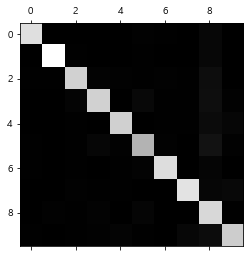

In [38]:
#matshow()을 통해 오차행렬을 이미지로 표현
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [39]:
#에러 비율
row_sums = conf_mx.sum(axis = 1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

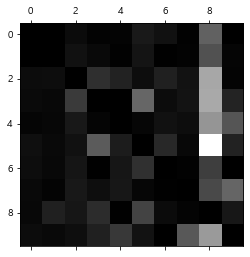

In [40]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [41]:
#숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

NameError: name 'matplotlib' is not defined

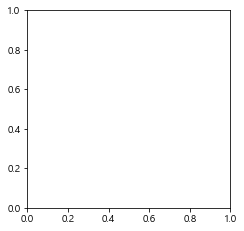

In [42]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()
#3/5의 에러롤 줄이는 방법은 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리 하는것

# 3.6 다중 레이블 분류
### 다중 레이블 분류 : 분류기가 샘플마다 여러개의 클래스를 출력하는 분류기

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 ==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeigihborsClassifier()
knn_clf.fit(X_train, y_multilable)

In [ ]:
knn_clf.predict([some_digit])

In [ ]:
#다중 레이블 분류기를 평가하는 방법 : F1 점수의 평균을 계산
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1.score(y_multilabel, y_train_knn_pred, average="macro")

# 3.7 다중 출력 분류
### 다중 출력 다중 클래스 분류(Multioutput-multiclass classification)
* 다중 레이블에서 한 레이블이 다중 클래스가 될 수 있도록 일반화 한것(값 두개 이상)

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [ ]:
#잡음 추가
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train+mod = X_train
y_test_mod = X_test

In [ ]:
some_index = 5501
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

In [ ]:
#잡음 제거
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)